In [1]:
# TODO Currently accesses .pos files from local directory. Must change to download from Zenodo when available
# Zachary Katz
# zachary_katz@mines.edu
# August 2024

# Make and save the catalog of Whillans Stick Slip Events from .pos files

# Imports
import os

import src.Catalog.Catalog as Catalog
import logging

# %load_ext line_profiler

################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/d/csrs_2024/all" 
stas = ["la01", "la02", "la03", "la04", "la05", "la06", "la07", "la08", "la09",
        "la10", "la11", "la12", "la13", "la14", "la15", "la16", "la17", "la18",
        "ws04", "ws05",
        "gz01", "gz02", "gz03", "gz04", "gz05", "gz06", "gz07", "gz08", "gz09",
        "gz10", "gz11", "gz12", "gz13", "gz14", "gz15", "gz16", "gz17", "gz18",
        "gz19", "gz20",
        "mg01", "mg02", "mg03", "mg04", "mg05", "mg06", "mg07",
        "slw1"
        ]
#year_arr = [["2007","2008","2009"],["2016","2017","2018","2019"]]
year_arr = [["2011"]]
stas = ['la05','la07','la08','gz01','gz03']

# Detection parameters
max_gap_len = 120 # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.
loglevel = "INFO" 


# fmt: on
########################## User Defined Variables ##############################
################################################################################

In [2]:
def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [3]:
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

2024-09-24 16:55:40 __main__ INFO: Creating Dataframe for la05


OSError: [Errno 19] No such device: '/mnt/d/csrs_2024/all/la05'

In [4]:
logger.info("Creating Catalog")

picks = Catalog.Picks(cats)
picks.lls_detection(window, slide)
merged_df = picks.merge()
sorted_list = picks.on_off_list()
picks.no_data_csv(sorted_list)

merged = Catalog.Events(merged_df)

2024-09-24 13:55:59 __main__ INFO: Creating Catalog
2024-09-24 13:55:59 src.Catalog.Catalog INFO: Linear Least Squares on la05
2024-09-24 13:57:03 src.Catalog.Catalog INFO: Linear Least Squares on la07
2024-09-24 13:57:53 src.Catalog.Catalog INFO: Linear Least Squares on la08
2024-09-24 13:58:29 src.Catalog.Catalog INFO: Linear Least Squares on gz01
2024-09-24 14:00:47 src.Catalog.Catalog INFO: Linear Least Squares on gz03


In [6]:
print(merged.merged)

                       time          la05x          la05y   la05res  \
0       2011-01-01 00:00:00 -231686.412955 -585204.348033  0.000000   
1       2011-01-01 00:00:15 -231686.407668 -585204.355983  0.000000   
2       2011-01-01 00:00:30 -231686.412355 -585204.348921  0.000000   
3       2011-01-01 00:00:45 -231686.418306 -585204.343311  0.000000   
4       2011-01-01 00:01:00 -231686.414904 -585204.339777  0.000000   
...                     ...            ...            ...       ...   
2102394 2011-12-31 23:58:30 -231413.112072 -585387.026218  0.000324   
2102395 2011-12-31 23:58:45 -231413.115642 -585387.029687  0.000324   
2102396 2011-12-31 23:59:00 -231413.117124 -585387.028125  0.000324   
2102397 2011-12-31 23:59:15 -231413.108001 -585387.025550  0.000324   
2102398 2011-12-31 23:59:30 -231413.120200 -585387.029512  0.000324   

         la05res_avg          la07x          la07y   la07res  la07res_avg  \
0           0.540692 -254210.823883 -529168.640473  0.000000     0.346

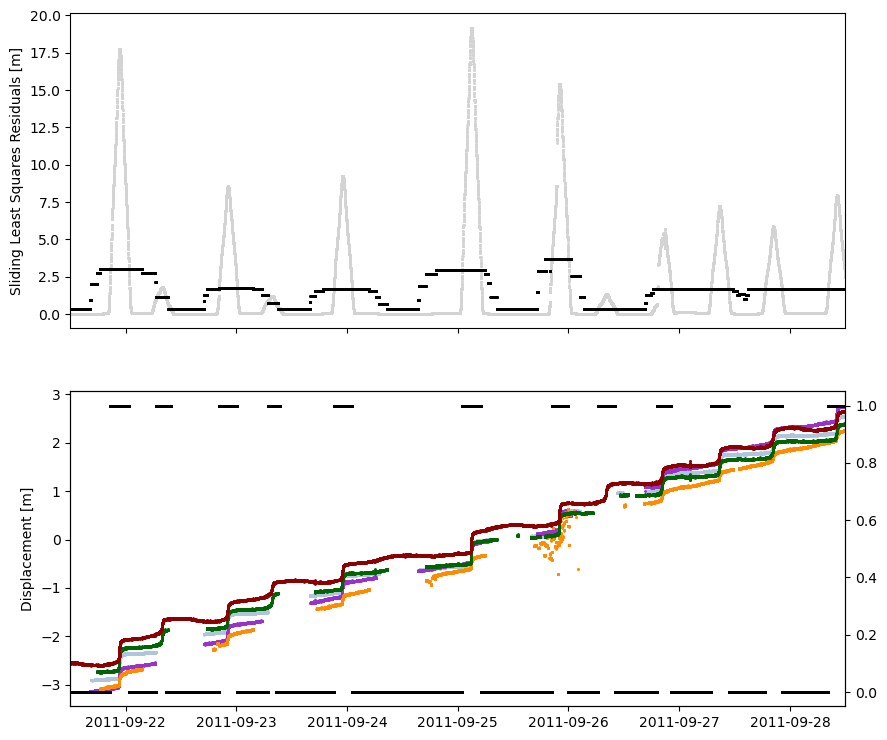

In [43]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax, ax2) = plt.subplots(2, figsize=(10, 9), sharex=True)
st_index = merged.merged[merged.merged["time"] == "2011-09-21T12:00:00"].index[0]
ed_index = merged.merged[merged.merged["time"] == "2011-09-28T12:00:00"].index[0]
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la05res'][st_index:ed_index],s=1,c='lightsteelblue')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la07res'][st_index:ed_index],s=1,c='darkorchid')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la08res'][st_index:ed_index],s=1,c='darkorange')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['gz01res'][st_index:ed_index],s=1,c='darkgreen')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['gz03res'][st_index:ed_index],s=1,c='darkred')

# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['gz01res_avg'][st_index:ed_index],s=1,c='darkgreen')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['gz03res_avg'][st_index:ed_index],s=1,c='darkred')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la05res_avg'][st_index:ed_index],s=1,c='lightsteelblue')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la07res_avg'][st_index:ed_index],s=1,c='darkorchid')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la08res_avg'][st_index:ed_index],s=1,c='darkorange')

sum_res_avg = np.nansum(
    merged.merged[
        ["la05res_avg", "la07res_avg", "la08res_avg", "gz01res_avg", "gz03res_avg"]
    ].iloc[st_index:ed_index],
    axis=1,
)

sum_res = np.nansum(
    merged.merged[["la05res", "la07res", "la08res", "gz01res", "gz03res"]].iloc[
        st_index:ed_index
    ],
    axis=1,
)
mean_res = np.nanmean(
    merged.merged[["la05res", "la07res", "la08res", "gz01res", "gz03res"]].iloc[
        st_index:ed_index
    ],
    axis=1,
)  # Nanmean skips nan
std_res = np.nanstd(
    merged.merged[["la05res", "la07res", "la08res", "gz01res", "gz03res"]].iloc[
        st_index:ed_index
    ],
    axis=1,
)  # Nanstd skips nan

ax.scatter(merged.merged["time"][st_index:ed_index], sum_res, s=1, c="lightgray")
ax.scatter(merged.merged["time"][st_index:ed_index], sum_res_avg, s=1, c="black")
merged.merged["sum_res_avg"] = sum_res_avg
merged.merged["sum_res"] = sum_res
# ax.scatter(merged.merged['time'][st_index:ed_index], mean_res,s=1,c='black')
# ax.scatter(merged.merged['time'][st_index:ed_index], std_res,s=1,c='black')

# ax2 = ax.twinx()
la05x = (
    merged.merged["la05x"][st_index:ed_index]
    - merged.merged["la05x"][st_index:ed_index].mean()
)
la07x = (
    merged.merged["la07x"][st_index:ed_index]
    - merged.merged["la07x"][st_index:ed_index].mean()
)
la08x = (
    merged.merged["la08x"][st_index:ed_index]
    - merged.merged["la08x"][st_index:ed_index].mean()
)
gz01x = (
    merged.merged["gz01x"][st_index:ed_index]
    - merged.merged["gz01x"][st_index:ed_index].mean()
)
gz03x = (
    merged.merged["gz03x"][st_index:ed_index]
    - merged.merged["gz03x"][st_index:ed_index].mean()
)

ax2.scatter(
    merged.merged["time"][st_index:ed_index], la05x, s=1, color="lightsteelblue"
)
ax2.scatter(merged.merged["time"][st_index:ed_index], la07x, s=1, color="darkorchid")
ax2.scatter(merged.merged["time"][st_index:ed_index], la08x, s=1, color="darkorange")
ax2.scatter(merged.merged["time"][st_index:ed_index], gz01x, s=1, color="darkgreen")
ax2.scatter(merged.merged["time"][st_index:ed_index], gz03x, s=1, color="darkred")
ax.set_xlim(merged.merged["time"][st_index], merged.merged["time"][ed_index])

ax.set_ylabel("Sliding Least Squares Residuals [m]")
ax2.set_ylabel("Displacement [m]")

ax3 = ax2.twinx()
ax3.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["event"][st_index:ed_index],
    s=1,
    c="black",
)

In [37]:
import pandas as pd
import numpy as np


def pick_events_test(self, sorted: pd.DataFrame, active_stas: int) -> float:
    """Get a of indices of when stations turn on/off. Updates Events in place

    Parameters
    ----------
    sorted: pd.DataFrame
        Sorted list of onsets and offsets made by on_off_list
    active_stas: int
        Minimum required number of active stations to consider an event

    Returns
    thresh: float
        Threshold value of summed residual for event detection
    """

    logger.info("Picking Events")
    # Find combined least square residual for each time block O(10 min)
    # Use the peaks and an average thresholding algortihm to pick out the events.
    x_cols = [col for col in self.merged.columns if col.endswith("x")]
    event = np.zeros(len(self.merged["sum_res"]))
    thresh = self.merged["sum_res_avg"]  # Threshold choice here e.g, avg + std
    x_col_check = active_stas - 1  # Indexed at 0 so subtract 1
    for i in range(len(event)):
        nansum = 0
        for col in x_cols:
            nan_check = self.merged[col][i]
            if np.isnan(nan_check):
                nansum += 1

        if (
            self.merged["sum_res"][i] > thresh[i] and nansum < len(x_cols) - x_col_check
        ):  # Check at least two non-nan cols
            event[i] = 1

    self.merged["event"] = event

    return thresh

In [38]:
threshold = pick_events_test(merged, sorted_list, active_stas=1)

2024-09-24 16:12:01 __main__ INFO: Picking Events


In [44]:
catalog = merged.make_catalog(cull_time=30, cull_dist=0.1)

save_dir = f"./{years[0]}_{years[-1]}Events"
Catalog.save_catalog(catalog, save_dir)

534


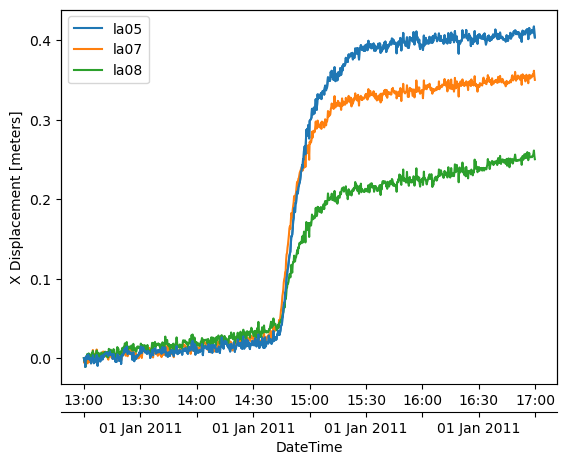

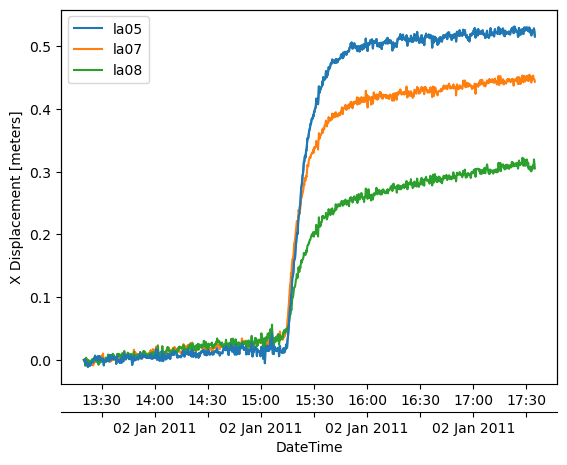

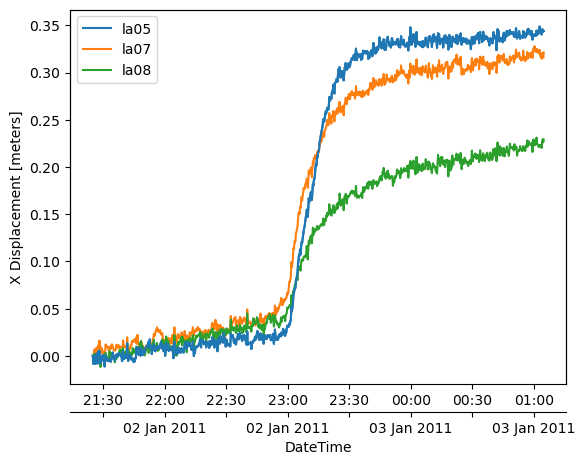

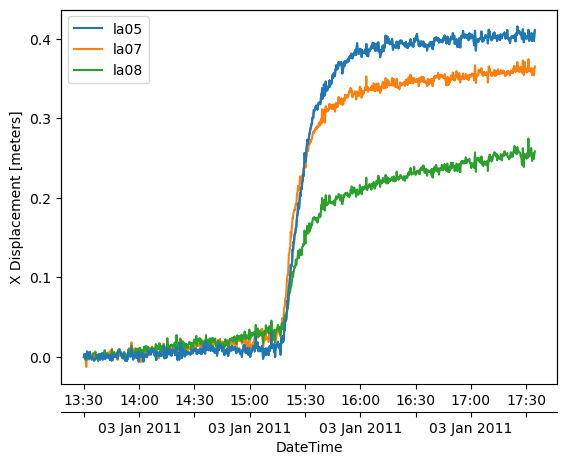

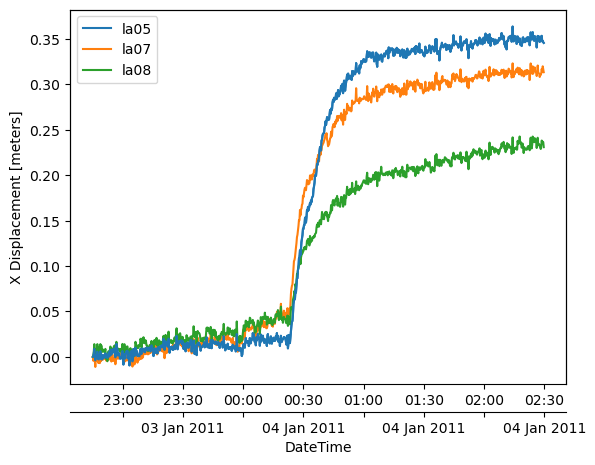

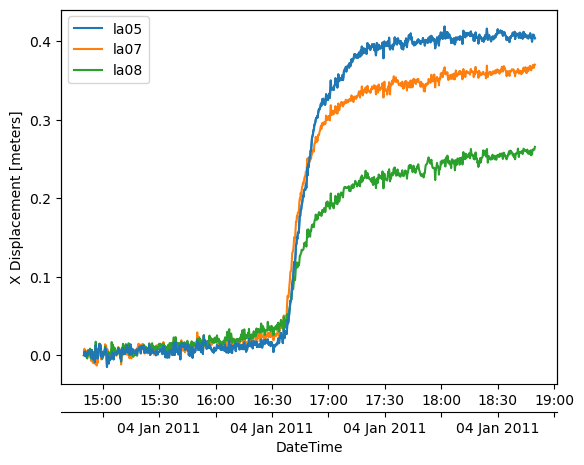

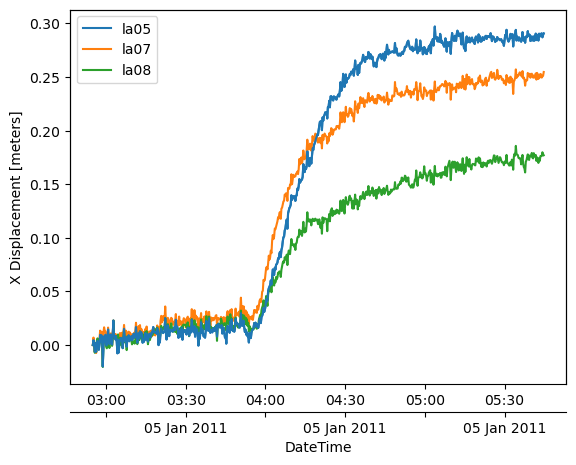

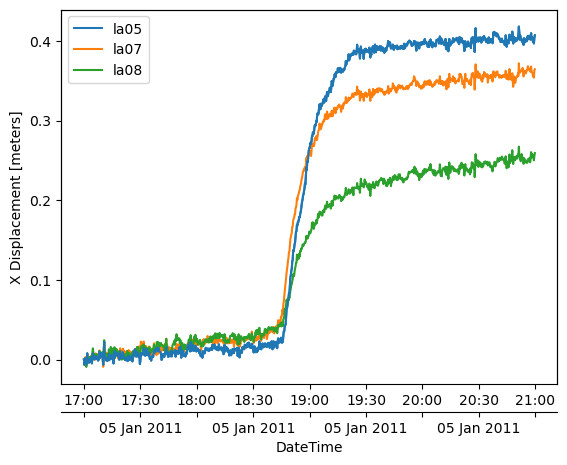

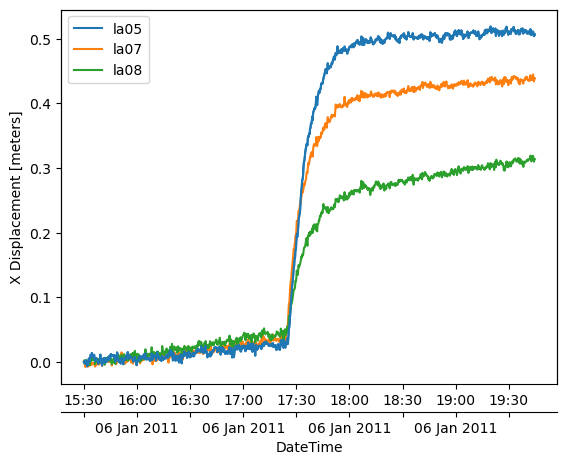

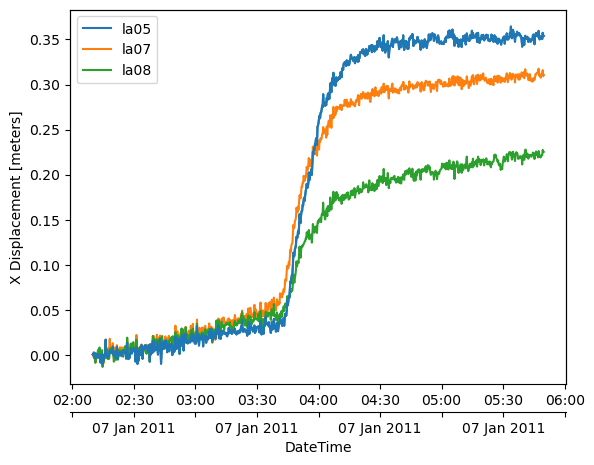

In [45]:
# Plot Example Events
print(len(catalog))
for event in catalog[:10]:
    Catalog.plot_event(event)

In [48]:
folders = [
    "2007_2009Events",
    "2010_2011Events",
    "2012_2013Events",
    "2014_2015Events",
    "2016_2019Events",
]
Catalog.event_start_time(folders, "2011EventStartTime")

AttributeError: module 'src.Catalog.Catalog' has no attribute 'event_start_time'